# 1) 데이터 준비와 확인

In [1]:
import os
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print("train data 개수: {}, test data 개수: {}".format(len(train_data), len(test_data)))  # 데이터 개수 확인
train_data.head()

train data 개수: 150000, test data 개수: 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data,test_data,num_words=10000):
    # document부분의 중복데이터를 제거해주고 수정본으로 바꾼다.
    # 결측치가 하나라도 있는 행 또는 열을 제거
    train_data.drop_duplicates(subset=['document'], inplace=True) 
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    # traindata안의 문장들 (형태소)토큰화 및 불용어 제거
    # 제거완료 후 X_train에 저장
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
        
    # testdata안의 문장들 (형태소)토큰화 및 불용어 제거
    # 제거완료 후 X_test에 저장
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # {word:index} 구조의 단어사전 구현 
    words = np.concatenate(X_train).tolist() # 데이터끼리 묶어줌
    counter = Counter(words) # 데이터(글자)수를 세어줌
    counter = counter.most_common(10000-4) # 많은 글자수 순으로 정렬
    vocab = ['<PAD>','<BOS>','<UNK>','<UNUSED>'] + [key for key, _ in counter] # pad,bos,unk.unused  + 나머지 vocab으로 저장
    word_to_index = {word:index for index, word in enumerate(vocab)} # enumerate사용해서 index로 치환

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [44]:
# 만든 사전 확인
index_to_word = {index:word for word, index in word_to_index.items()}
#print(index_to_word)
#10000개의 단어가 나와서 주석처리

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
# encode된 텍스트가 정상적으로 decode되는지 확인
for i in range(5):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i],index_to_word),'\n')

print("-----------------------------------------------------")
    
for i in range(5):
    print(X_test[i])
    print(get_decoded_sentence(X_test[i],index_to_word),'\n')

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리 

[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나 

[24, 205, 2]
재 <UNK> 

[8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]
이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정 

[2, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 2, 2, 427, 3102, 1766, 6]
익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다 

-----------------------------------------------------
[832, 130]
ㅋ 

[2]
 

[85, 111, 58, 4, 70, 950, 332, 44, 38, 100, 37, 641, 3557, 73, 917]
야 평점 . ... 나쁘 진 않 지만 10 점 짜리 더더욱 아니 잖아 

[96, 8, 15, 44, 231, 137, 357, 129, 4, 11, 153, 54, 7, 10, 42, 4, 70]
하 지 않 은데 완전 막장 임 . .. 돈 주 고 보 기 . ... 

[131, 1114, 22, 73, 21, 459, 232, 2142, 122, 559, 9, 596, 4, 4, 63, 131, 1114, 29, 635, 346, 2, 844, 8, 12, 8, 295, 18, 18]
D 만 아니 었 어도 별 다섯 개 줬 을 텐데 . . 왜 3 D 로 나와서 제 <UNK> 불편 하 게 하 죠 ? ? 



# 3) 모델구성을 위한 데이터 분석 및 가공

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# 4) 모델구성 및 validation set 구성

In [8]:
# 훈련 수:146182, 테스트 개수: 49157
# 146182 중 39000개를 validation set으로 사용
x_val = X_train[:30000]
y_val = y_train[:30000]

# 나머지를 train set으로 사용
partial_x_train = X_train[30000:]
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


### 1. LSTM

In [9]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

LSTMmodel = keras.Sequential()
LSTMmodel.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTMmodel.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
LSTMmodel.add(keras.layers.Dense(8, activation='relu'))
LSTMmodel.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

LSTMmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


### 2. 1-D CNN

In [10]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

D1CNNmodel = keras.Sequential()
D1CNNmodel.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
D1CNNmodel.add(keras.layers.Conv1D(16, 7, activation='relu'))
D1CNNmodel.add(keras.layers.MaxPooling1D(5))
D1CNNmodel.add(keras.layers.Conv1D(16, 7, activation='relu'))
D1CNNmodel.add(keras.layers.GlobalMaxPooling1D())
D1CNNmodel.add(keras.layers.Dense(8, activation='relu'))
D1CNNmodel.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

D1CNNmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### 3. GlobalMaxPooling1D

In [11]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

GMP1Dmodel = keras.Sequential()
GMP1Dmodel.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP1Dmodel.add(keras.layers.GlobalMaxPooling1D())
GMP1Dmodel.add(keras.layers.Dense(8, activation='relu'))
GMP1Dmodel.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

GMP1Dmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


# 5) 모델 훈련 개시
# 6) Loss, Accuracy 그래프 시각화

### 1. LSTM

In [12]:
# 모델 학습
LSTMmodel.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
              
epochs = 7 

history1 = LSTMmodel.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)

Epoch 1/7
227/227 [==============================] - 10s 33ms/step - loss: 0.5514 - accuracy: 0.7513 - val_loss: 0.3492 - val_accuracy: 0.8484
Epoch 2/7
227/227 [==============================] - 6s 28ms/step - loss: 0.3228 - accuracy: 0.8664 - val_loss: 0.3347 - val_accuracy: 0.8533
Epoch 3/7
227/227 [==============================] - 6s 29ms/step - loss: 0.2859 - accuracy: 0.8817 - val_loss: 0.3325 - val_accuracy: 0.8556
Epoch 4/7
227/227 [==============================] - 6s 29ms/step - loss: 0.2602 - accuracy: 0.8939 - val_loss: 0.3383 - val_accuracy: 0.8546
Epoch 5/7
227/227 [==============================] - 7s 29ms/step - loss: 0.2350 - accuracy: 0.9071 - val_loss: 0.3500 - val_accuracy: 0.8553
Epoch 6/7
227/227 [==============================] - 6s 29ms/step - loss: 0.2119 - accuracy: 0.9187 - val_loss: 0.3604 - val_accuracy: 0.8546
Epoch 7/7
227/227 [==============================] - 6s 28ms/step - loss: 0.1920 - accuracy: 0.9268 - val_loss: 0.3790 - val_accuracy: 0.8519


In [13]:
# testset으로 평가
results = LSTMmodel.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 5s - loss: 0.3861 - accuracy: 0.8473


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


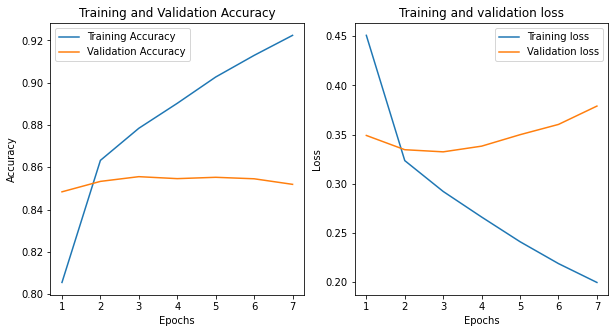

In [14]:
# 시각화
history_dict = history1.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 2. 1-D CNN

In [15]:
# 모델 학습
D1CNNmodel.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

epochs = 7

history2 = D1CNNmodel.fit(partial_x_train,
                          partial_y_train,
                          epochs=epochs,
                          batch_size=512,
                          validation_data=(x_val, y_val),
                          verbose=1)

Epoch 1/7
227/227 [==============================] - 14s 48ms/step - loss: 0.5413 - accuracy: 0.7135 - val_loss: 0.3392 - val_accuracy: 0.8524
Epoch 2/7
227/227 [==============================] - 7s 30ms/step - loss: 0.3007 - accuracy: 0.8756 - val_loss: 0.3267 - val_accuracy: 0.8585
Epoch 3/7
227/227 [==============================] - 7s 29ms/step - loss: 0.2386 - accuracy: 0.9068 - val_loss: 0.3363 - val_accuracy: 0.8579
Epoch 4/7
227/227 [==============================] - 7s 29ms/step - loss: 0.1637 - accuracy: 0.9425 - val_loss: 0.3762 - val_accuracy: 0.8528
Epoch 5/7
227/227 [==============================] - 7s 30ms/step - loss: 0.1032 - accuracy: 0.9670 - val_loss: 0.4634 - val_accuracy: 0.8464
Epoch 6/7
227/227 [==============================] - 7s 30ms/step - loss: 0.0632 - accuracy: 0.9807 - val_loss: 0.5281 - val_accuracy: 0.8425
Epoch 7/7
227/227 [==============================] - 7s 29ms/step - loss: 0.0428 - accuracy: 0.9870 - val_loss: 0.6062 - val_accuracy: 0.8405


In [16]:
# testset으로 평가
results = D1CNNmodel.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 5s - loss: 0.6411 - accuracy: 0.8342


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


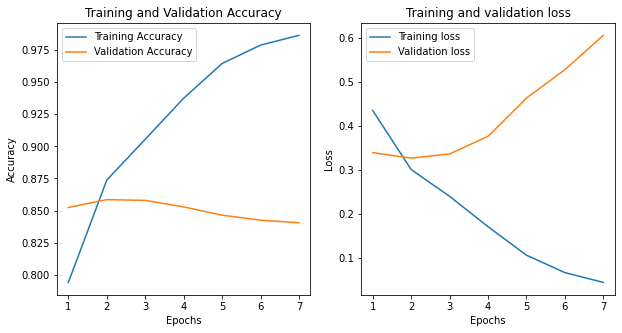

In [17]:
# 시각화
history_dict = history2.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 3. GlobalMaxPooling1D

In [18]:
# 모델 학습
GMP1Dmodel.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

epochs = 7

history3 = GMP1Dmodel.fit(partial_x_train,
                          partial_y_train,
                          epochs=epochs,
                          batch_size=512,
                          validation_data=(x_val, y_val),
                          verbose=1)

Epoch 1/7
227/227 [==============================] - 6s 25ms/step - loss: 0.5937 - accuracy: 0.7265 - val_loss: 0.3580 - val_accuracy: 0.8433
Epoch 2/7
227/227 [==============================] - 5s 24ms/step - loss: 0.3278 - accuracy: 0.8626 - val_loss: 0.3358 - val_accuracy: 0.8535
Epoch 3/7
227/227 [==============================] - 5s 24ms/step - loss: 0.2710 - accuracy: 0.8916 - val_loss: 0.3365 - val_accuracy: 0.8544
Epoch 4/7
227/227 [==============================] - 5s 24ms/step - loss: 0.2304 - accuracy: 0.9116 - val_loss: 0.3493 - val_accuracy: 0.8556
Epoch 5/7
227/227 [==============================] - 5s 24ms/step - loss: 0.1924 - accuracy: 0.9305 - val_loss: 0.3673 - val_accuracy: 0.8523
Epoch 6/7
227/227 [==============================] - 5s 24ms/step - loss: 0.1532 - accuracy: 0.9483 - val_loss: 0.3952 - val_accuracy: 0.8517
Epoch 7/7
227/227 [==============================] - 5s 24ms/step - loss: 0.1160 - accuracy: 0.9650 - val_loss: 0.4282 - val_accuracy: 0.8493


In [19]:
# testset으로 평가
results = GMP1Dmodel.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.4432 - accuracy: 0.8429


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


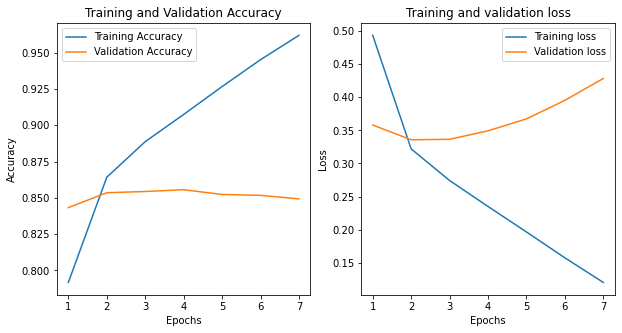

In [20]:
# 시각화
history_dict = history3.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 7) 학습된 Embedding 레이어 분석

In [21]:
embedding_layer = LSTMmodel.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [22]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씀

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = LSTMmodel.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [23]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
# word vector를 확인
vector = word_vectors['영화']
vector

array([-0.05408233, -0.07923312, -0.07333188,  0.01427919, -0.02996428,
        0.02342098,  0.04339524,  0.03521543, -0.06725108, -0.02632448,
       -0.09787676,  0.02828034,  0.04429861, -0.10128447,  0.02464617,
       -0.00525555, -0.01935657,  0.05010162,  0.02702129,  0.11865626,
        0.01154231, -0.02509702,  0.05490542,  0.02063285, -0.02776157,
       -0.00264144,  0.02897376, -0.06673321, -0.05603962, -0.06958181,
        0.10416506, -0.15967947,  0.00565122,  0.06770159, -0.03494377,
       -0.08606029,  0.01925514, -0.04228349,  0.05293547,  0.03557471,
        0.01989474,  0.03633023,  0.06233719, -0.01348058, -0.06899197,
        0.01228596, -0.07555053, -0.08355996,  0.06932788, -0.01885492,
        0.02334792,  0.03873186,  0.09283781, -0.00517423, -0.07605793,
        0.04469941,  0.04594416, -0.01931314, -0.02884266,  0.03330001,
       -0.03563881,  0.03071698, -0.04877485,  0.00145446, -0.01781845,
        0.01913157,  0.01965923, -0.03506095,  0.00062177,  0.10

In [24]:
# 가장 유사한 단어와 그 유사도를 확인
word_vectors.similar_by_word("영화")

[('ㅜㅜ', 0.7277578115463257),
 ('네요', 0.7220390439033508),
 ('습니다', 0.7200484275817871),
 ('음', 0.7093784809112549),
 ('~~', 0.6846742630004883),
 ('씀', 0.6819763779640198),
 ('다', 0.6795774698257446),
 ('"""', 0.6726246476173401),
 ('^^♥', 0.6691598296165466),
 ('넘침', 0.6672155857086182)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [25]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector     # 무려 300dim의 워드 벡터입니다.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [26]:
word2vec.similar_by_word("영화")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

In [27]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [39]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
WLSTMmodel = keras.Sequential()
WLSTMmodel.add(keras.layers.Embedding(vocab_size, 
                                      word_vector_dim, 
                                      embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                      input_length=maxlen, 
                                      trainable=True))   # trainable을 True로 주면 Fine-tuning
WLSTMmodel.add(keras.layers.LSTM(8))
WLSTMmodel.add(keras.layers.Dropout(0.4))
WLSTMmodel.add(keras.layers.Dense(8, activation='relu'))
WLSTMmodel.add(keras.layers.Dense(1, activation='sigmoid')) 

WLSTMmodel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [40]:
WLSTMmodel.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
              
epochs = 7

history4 = WLSTMmodel.fit(partial_x_train,
                          partial_y_train,
                          epochs=epochs,
                          batch_size=512,
                          validation_data=(x_val, y_val),
                          verbose=1)

Epoch 1/7
227/227 [==============================] - 9s 31ms/step - loss: 0.6363 - accuracy: 0.6248 - val_loss: 0.4252 - val_accuracy: 0.8147
Epoch 2/7
227/227 [==============================] - 7s 29ms/step - loss: 0.4262 - accuracy: 0.8164 - val_loss: 0.3658 - val_accuracy: 0.8433
Epoch 3/7
227/227 [==============================] - 7s 29ms/step - loss: 0.3590 - accuracy: 0.8514 - val_loss: 0.3452 - val_accuracy: 0.8513
Epoch 4/7
227/227 [==============================] - 7s 29ms/step - loss: 0.3291 - accuracy: 0.8672 - val_loss: 0.3399 - val_accuracy: 0.8556
Epoch 5/7
227/227 [==============================] - 7s 29ms/step - loss: 0.3102 - accuracy: 0.8738 - val_loss: 0.3396 - val_accuracy: 0.8556
Epoch 6/7
227/227 [==============================] - 7s 29ms/step - loss: 0.2916 - accuracy: 0.8843 - val_loss: 0.3380 - val_accuracy: 0.8592
Epoch 7/7
227/227 [==============================] - 6s 29ms/step - loss: 0.2840 - accuracy: 0.8873 - val_loss: 0.3400 - val_accuracy: 0.8580


In [41]:
# testset으로 평가
results = WLSTMmodel.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 5s - loss: 0.3534 - accuracy: 0.8519


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


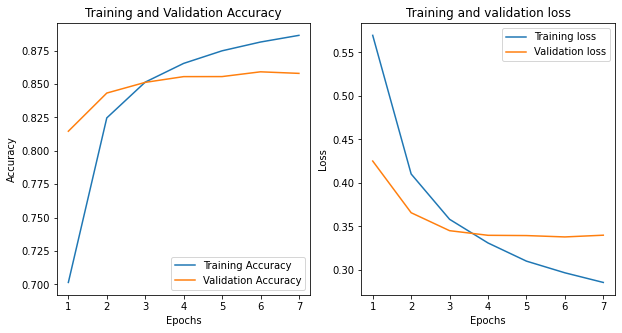

In [42]:
# 시각화
history_dict = history4.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

---
# 회고
1. LSTM, 1-D CNN, GlobalMaxPooling1D 총 3가지 모델을 시도해보았다.   
83~84%의 정확도였고 loss 값은 LSTM,GlobalMaxPooling1D,1-D CNN 순으로 낮았다.   
epoch을 늘리면 늘릴수록 의미가 없다는것을 그래프로 확인을 하여서 기존 10번에서 7번으로 낮추었다.


2. gensim의 유사 단어 찾기를 활용하여서 가장 좋았던 LSTM으로 자체 학습한 임베딩은 '영화'라는 단어에 관련이 없는 단어들이 나왔지만
한글word2vec의 사전학습된 임베딩을 이용하니 '영화사','영화인','드라마' 등 유사단어들이 매우 잘 나오는것을 보아 사전에 학습된것이 얼마나 중요한지를 알 수 가 있었다.


3. epoch를 더 낮추지 않고 dropout을 이용해서 오버피팅을 막아보자고 생각해서, 가장 성능이 좋았던 LSTM모델에 한글word2vec 임베딩을 활용해서 모델을 돌려보았더니 85.19%로 약 0.5%올랐지만 loss값이 3%나 낮아진것을 확인할 수 있었다. 역시나 사전학습된 임베딩을 이용하면 성능향상하는데 매우 좋다는 것을 느꼈다.